In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

register_matplotlib_converters()
from time import time

In [7]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [8]:
#read data
df=pd.read_csv('/Users/wypa/Google Drive/MSc WIN/05_HS2020/VMAT/Data/final_df.csv', squeeze=True, date_parser=parser)
df=df[['Date','shelter']]
df.Date=pd.to_datetime(df.Date)
df=df.drop_duplicates(subset=['Date'])
df=df.set_index('Date')
df=pd.Series(df.shelter)

In [9]:
start_date = datetime(2013,1,1)
end_date = datetime(2019,12,31)
lim_df = df[start_date:end_date]

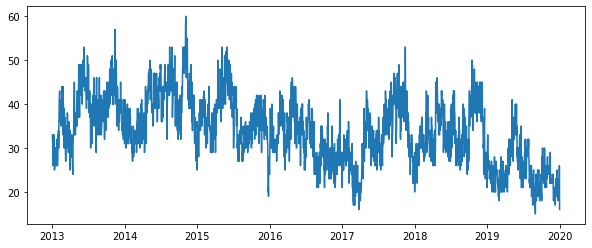

In [10]:
plt.figure(figsize=(10,4))
plt.plot(lim_df)

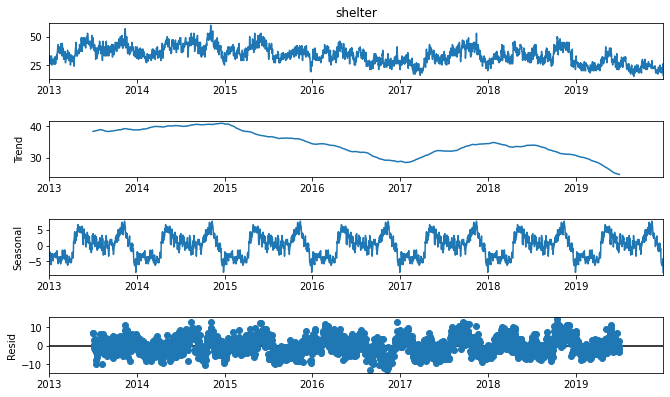

In [11]:
decomposed = seasonal_decompose(lim_df,period=365)

fig = decomposed.plot()
fig.set_figheight(6)
fig.set_figwidth(10)
plt.show()

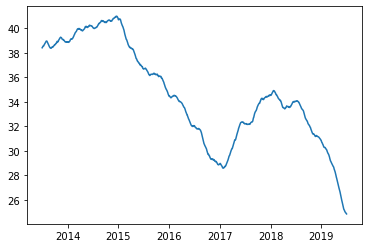

In [14]:
plt.plot(decomposed.trend)

In [7]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(lim_df,regression='c')
print('p-value:{}'.format(res[1]))

p-value:0.01819484881339632


In [8]:
res = sm.tsa.adfuller(lim_df.diff().dropna())
print('p-value:{}'.format(res[1]))

p-value:3.6732409668532906e-21


AttributeError: 'AxesSubplot' object has no attribute 'set_length'

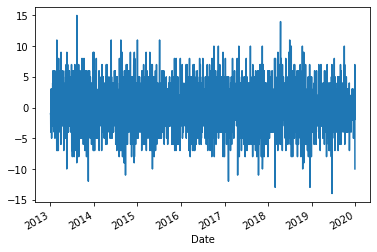

In [9]:
first_diff=lim_df.diff().dropna()
fig=first_diff.plot()
fig.set_length(10)
fig.set_width(4)

# ACF

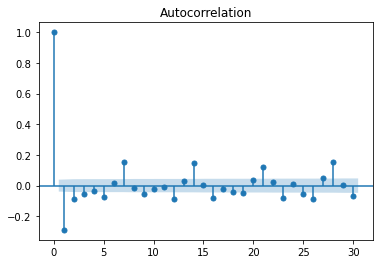

In [10]:
acf_plot=plot_acf(first_diff,lags=30)

## the ACF suggests a weekly repeating pattern & moderate negative correlation with the next day value

# PACF

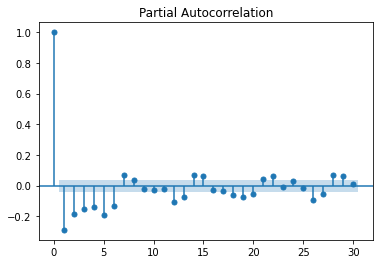

In [11]:
pacf_plot=plot_pacf(first_diff,lags=30)

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [12]:
train_data = lim_df.loc[:'2018-12-31']
test_data = lim_df.loc['2019-01-01':'2019-12-31']

#train_data = lim_df[:train_end]
#test_data = lim_df[train_end + timedelta(days=1):test_end]

In [13]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(lim_df, trace=True,min_ar=7, max_ma=7,
suppress_warnings=True,seasonal=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13334.725, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13827.016, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13606.338, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13453.754, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13825.024, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13333.457, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13350.754, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13331.457, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13333.457, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13517.982, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13329.501, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13451.777, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13604.349, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=13331.501, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2551
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6661.751
Date:                Wed, 15 Sep 2021   AIC                          13329.501
Time:                        09:37:33   BIC                          13347.033
Sample:                             0   HQIC                         13335.860
                               - 2551                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3707      0.029     12.684      0.000       0.313       0.428
ma.L1         -0.8031      0.019    -43.271      0.000      -0.839      -0.767
sigma2        10.8792      0.290     37.499      0.000      10.311      11.448
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.56
Prob(Q):                              1.00   Prob(JB):                         0.06
Heteroskedasticity (H):               0.92   Skew:                             0.04
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fit the SARIMA Model

In [14]:
my_order = (7,1,1)
my_seasonal_order = (0, 0, 0, 0)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

/Users/wypa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/wypa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [15]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.5608391761779785


In [16]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                shelter   No. Observations:                 2186
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5726.603
Date:                Wed, 15 Sep 2021   AIC                          11471.206
Time:                        09:37:34   BIC                          11522.410
Sample:                             0   HQIC                         11489.923
                               - 2186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2019      0.249     -0.811      0.418      -0.690       0.286
ar.L2         -0.2186      0.107     -2.037      0.042      -0.429      -0.008
ar.L3         -0.1983      0.084     -2.351      0.0

/Users/wypa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


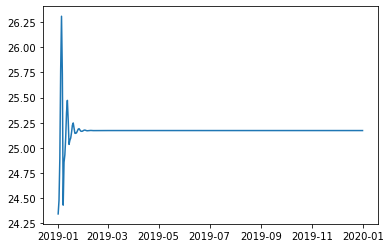

In [17]:
#get the predictions and residuals
predictions = pd.DataFrame(model_fit.forecast(len(test_data)))
idx = pd.date_range("2019", freq="D", periods=365)
predictions=predictions.set_index(idx)
predictions=pd.Series(predictions.predicted_mean)
plt.plot(predictions)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

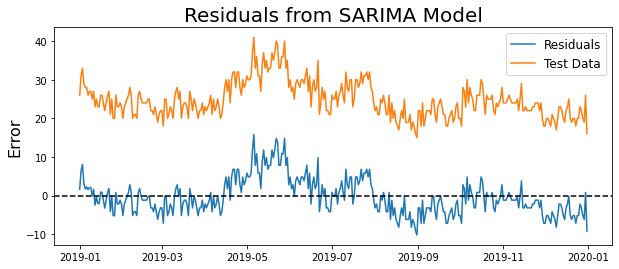

In [18]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.plot(test_data)
plt.legend(('Residuals', 'Test Data'), fontsize=12)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

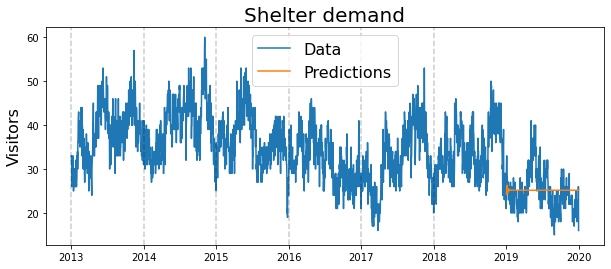

In [19]:
plt.figure(figsize=(10,4))

plt.plot(lim_df)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Shelter demand', fontsize=20)
plt.ylabel('Visitors', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [20]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.1514


In [21]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 4.6298638825308815


# Using the Rolling Forecast Origin

In [22]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_df[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/Users/wypa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/wypa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/wypa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/wypa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, b

In [23]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

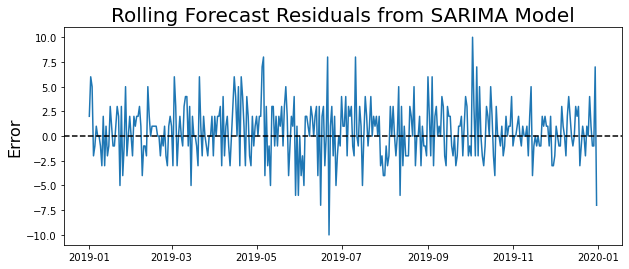

In [24]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

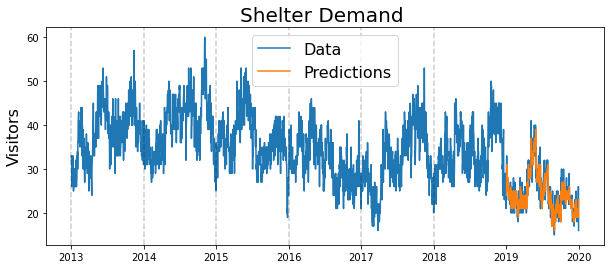

In [25]:
plt.figure(figsize=(10,4))

plt.plot(lim_df)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Shelter Demand ', fontsize=20)
plt.ylabel('Visitors', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

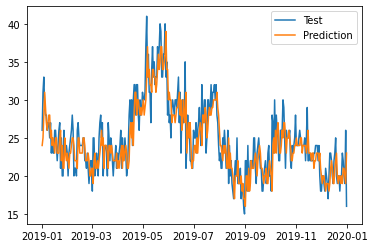

In [26]:
plt.plot(lim_df['2019-01-01':])
plt.plot(rolling_predictions)
plt.legend(('Test','Prediction'))

In [27]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0872


In [28]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 2.7864643478149573
